/tmp/ipykernel_568498/2993371071.py:47: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[    0.      0.      0.  ... 33623.  44229.5 47525.2]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



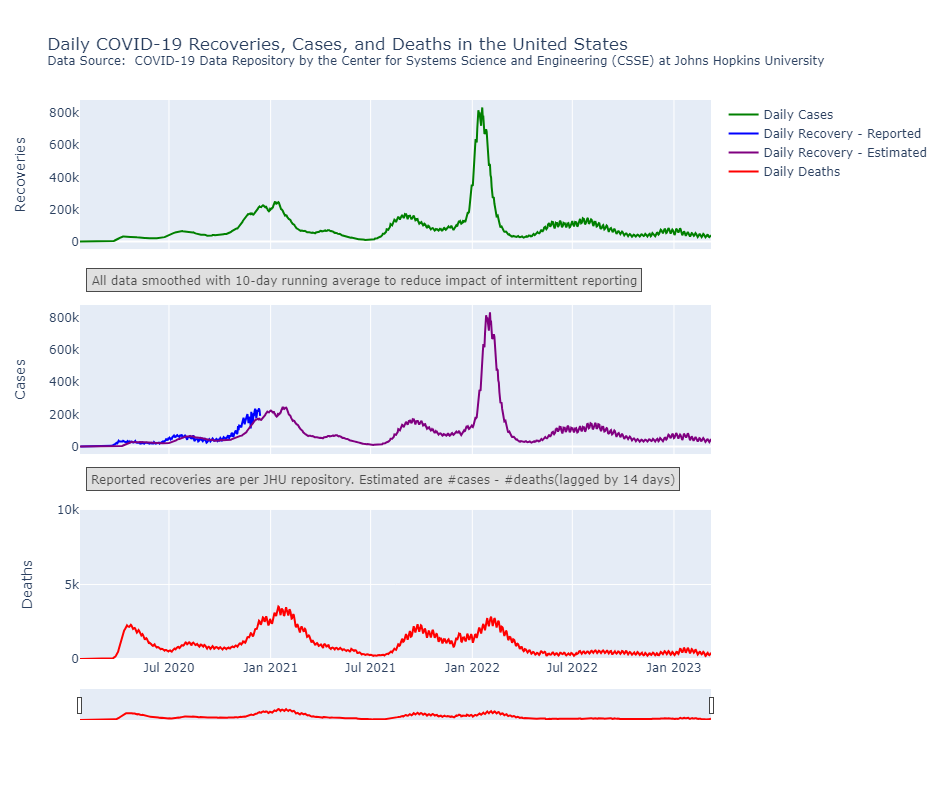

In [32]:
import pandas as pd
import ssl #you can comment this line
import plotly.subplots
import plotly.graph_objects
import numpy as np

#ssl._create_default_https_context = ssl._create_unverified_context  #you can comment this line

dat = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

dat = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
US_data = dat[dat['Country/Region'] == 'US'].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1)
US_data.reset_index(inplace=True)
US_data = pd.melt(US_data, id_vars='index', var_name='Date', value_name='CumulativeDeaths')
US_data['DailyDeaths'] = US_data['CumulativeDeaths'].diff()
US_data['Date'] = pd.to_datetime(US_data['Date'], format='%m/%d/%y')
US_data['Smoothed_deaths'] = US_data['DailyDeaths'].rolling(window=10).mean().astype(float) 
US_data['Smoothed_deaths'] = US_data['Smoothed_deaths'].fillna(0) 
US_deaths = US_data.copy()

dat = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
US_data = dat[dat['Country/Region'] == 'US'].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1)
US_data.reset_index(inplace=True)
US_data = pd.melt(US_data, id_vars='index', var_name='Date', value_name='CumulativeCases')
US_data['DailyCases'] = US_data['CumulativeCases'].diff()
US_data['Date'] = pd.to_datetime(US_data['Date'], format='%m/%d/%y')
US_data['Smoothed_cases'] = US_data['DailyCases'].rolling(window=10).mean().astype(float) 
US_data['Smoothed_cases'] = US_data['Smoothed_cases'].fillna(0) 
US_cases = US_data.copy()

US_data = dat[dat['Country/Region'] == 'US'].drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1)
US_data.reset_index(inplace=True)
US_data = pd.melt(US_data, id_vars='index', var_name='Date', value_name='CumulativeRecovery')
US_data['DailyRecovery'] = US_data['CumulativeRecovery'].diff()
US_data['Date'] = pd.to_datetime(US_data['Date'], format='%m/%d/%y')
#US_data['Smoothed_recoveries'] = US_data['DailyRecovery'].rolling(window=10).mean
US_recovery = US_data[US_data['Date'] < '2020-12-14'].copy()
US_data = US_deaths.merge(US_recovery, on='Date', how='outer').merge(US_cases, on='Date', how='outer')


#Calculated recoveries = cases on day 14 minus deaths on day 1

# Create a new column 'Calc_recoveries' and set all values to 0
US_data['Calc_recoveries'] = 0

# Calculate 'Calc_recoveries' for rows 14 onwards
US_data.loc[14:, 'Calc_recoveries'] = -US_data.loc[14:, 'Smoothed_deaths'].values + US_data.loc[:len(US_data)-15, 'Smoothed_cases'].values
#still getting a future warning for this, likely need to be cautious with resulting data shape/format

#print(US_data)

fig = plotly.subplots.make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1)


fig.add_trace(
    plotly.graph_objects.Scatter(
        x=US_data['Date'], 
        y=US_data['Smoothed_cases'], 
        mode='lines', 
        name='Daily Cases',
        line=dict(color='green')
    ), row=1, col=1
)

fig.add_trace(
    plotly.graph_objects.Scatter(
        x=US_data['Date'], 
        y=US_data['DailyRecovery'],
        #y=US_data['Smoothed_recoveries'], 
        mode='lines', 
        name='Daily Recovery - Reported',
        line=dict(color='blue')
    ), row=2, col=1
)
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=US_data['Date'], 
        y=US_data['Calc_recoveries'],
        #y=US_data['Smoothed_recoveries'], 
        mode='lines', 
        name='Daily Recovery - Estimated',
        line=dict(color='purple')
    ), row=2, col=1
)

fig.add_trace(
    plotly.graph_objects.Scatter(
        x=US_data['Date'], 
        y=US_data['Smoothed_deaths'], 
        mode='lines', 
        name='Daily Deaths',
        line=dict(color='red')
        
    ), row=3, col=1
)

fig.update_yaxes(range=[0, 10000], row=3, col=1)

fig.update_layout(
    title='Daily COVID-19 Recoveries, Cases, and Deaths in the United States <br><sup>Data Source: <a href="https://github.com/CSSEGISandData/COVID-19"> COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University </a> </sup>',
    height=800,
    xaxis=dict( showticklabels=False),
    yaxis=dict(title='Recoveries', showline=False, showgrid=False),  
    yaxis2=dict(title='Cases', showline=False, showgrid=False),  
    yaxis3=dict(title='Deaths', showline=False, showgrid=False),  
    yaxis3_showgrid=True, 
    xaxis3=dict(rangeslider=dict(visible=True, thickness=0.05), type="date")
)

# Add a text box just inside the first graph
fig.add_annotation(
    xref='paper',
    yref='paper',
    x=0.01,  # Adjust this value to position the text box horizontally
    y= 0.7,  # Adjust this value to position the text box vertically
    text="All data smoothed with 10-day running average to reduce impact of intermittent reporting",
    showarrow=False,
    font=dict(
        size=12,
        color="black"
    ),
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    bgcolor="lightgrey",
    opacity=0.7
)
# Add a text box next to the second graph
fig.add_annotation(
    xref='paper',
    yref='paper',
    x=.01,  # Adjust this value to position the text box horizontally
    y=.3,  # Adjust this value to position the text box vertically
    text="Reported recoveries are per JHU repository. Estimated are #cases - #deaths(lagged by 14 days)",
    showarrow=False,
    font=dict(
        size=12,
        color="black"
    ),
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    bgcolor="lightgrey",
    opacity=0.7
)
fig.show()
fig.write_html("index_v3_10.html")